[*********************100%***********************]  1 of 1 completed

Date
2020-01-02    339.0
2020-01-03    339.5
2020-01-06    332.0
2020-01-07    329.5
2020-01-08    329.5
Name: Close, dtype: float64


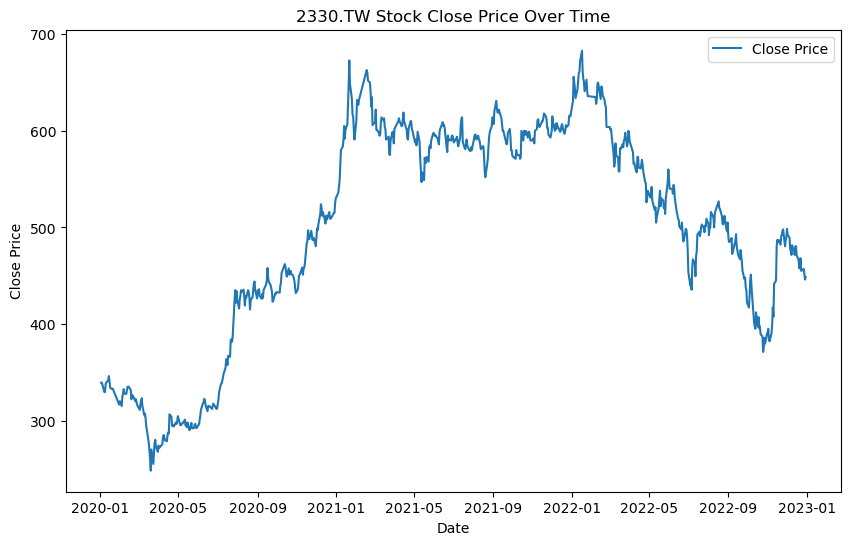

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

stock_symbol = '2330.TW'
stock_data = yf.download(stock_symbol, start="2020-01-01", end="2023-01-01")

close_prices = stock_data['Close']

print(close_prices.head())

plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title(f'{stock_symbol} Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 定義最佳化 ARIMA 模型參數的函數
def optimize_arima(train, test, p_values, d_values, q_values):
    """
    找出最佳的 ARIMA 模型參數 (p, d, q)
    :param train: 訓練數據集
    :param test: 測試數據集
    :param p_values: p參數的範圍
    :param d_values: d參數的範圍
    :param q_values: q參數的範圍
    :return: 最佳參數與模型
    """
    best_score, best_cfg = float("inf"), None
    best_model = None
    
    # 使用迴圈遍歷所有可能的 (p, d, q) 組合
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    yhat = model_fit.forecast(steps=len(test))
                    error = mean_squared_error(test, yhat)
                    if error < best_score:
                        best_score, best_cfg = error, (p, d, q)
                        best_model = model_fit
                except:
                    continue
    return best_cfg, best_model


最佳參數: (4, 2, 0)


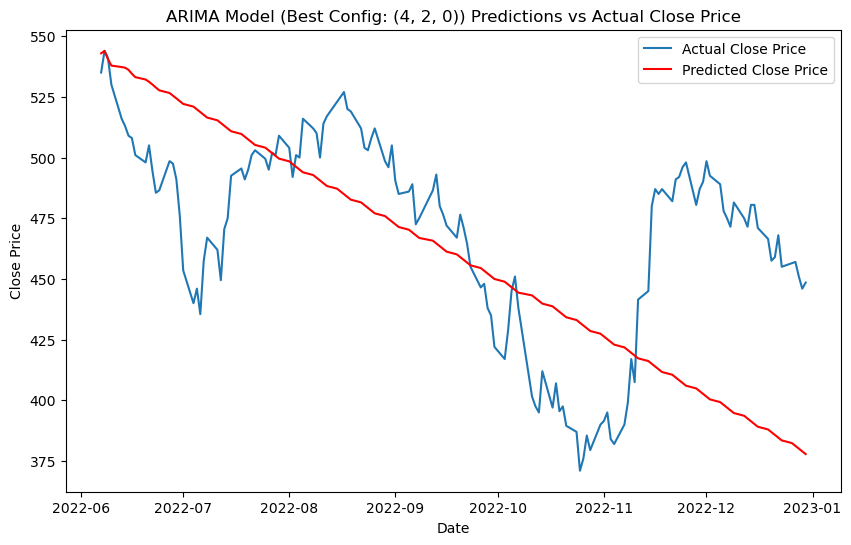

In [4]:
# 將資料分成訓練集和測試集 (可以調整測試集大小)
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

# 定義 p, d, q 參數範圍
p_values = range(0, 6)  # p 範圍 0~5
d_values = range(0, 3)  # d 範圍 0~2
q_values = range(0, 6)  # q 範圍 0~5

# 找出 ARIMA 模型的最佳參數
best_cfg, best_model = optimize_arima(train, test, p_values, d_values, q_values)

# 印出最佳參數
print(f'最佳參數: {best_cfg}')

# 使用最佳模型進行預測
predictions = best_model.forecast(steps=len(test))

# 繪製預測結果與實際結果的對比
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Close Price')
plt.plot(test.index, predictions, label='Predicted Close Price', color='red')
plt.title(f'ARIMA Model (Best Config: {best_cfg}) Predictions vs Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [5]:
import backtrader as bt
import yfinance as yf
import numpy as np

# 設定交易策略，增加了進場、出場條件和更多的移動平均指標
class SmaCross(bt.Strategy):
    params = (
        ('short_period', 5),  # 短期移動平均線
        ('long_period', 20),  # 長期移動平均線
        ('atr_period', 14),   # ATR 用於波動率止損
        ('stop_loss', 0.02),  # 固定止損比例 (2%)
        ('take_profit', 0.05)  # 固定止盈比例 (5%)
    )
    
    def __init__(self):
        # 移動平均線
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_period)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_period)
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)  # 黃金/死亡交叉指標
        
        # 波動率止損
        self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period)
    
    def next(self):
        if not self.position:  # 沒有持倉時
            if self.crossover > 0:  # 黃金交叉，買入
                size = self.broker.getcash() // self.data.close[0]  # 買入最大可能的數量
                self.buy(size=size)
        elif self.position:  # 有持倉時
            # 固定止損和止盈
            if (self.data.close[0] >= self.position.price * (1 + self.params.take_profit)) or \
               (self.data.close[0] <= self.position.price * (1 - self.params.stop_loss)):
                self.sell()  # 出場

# 定義回測方法並加入績效指標計算
class MyAnalyzer(bt.Analyzer):
    def __init__(self):
        self.rets = []

    def notify_trade(self, trade):
        if trade.isclosed:
            self.rets.append(trade.pnl)

    def get_analysis(self):
        total_trades = len(self.rets)
        win_trades = sum(1 for i in self.rets if i > 0)
        lose_trades = total_trades - win_trades
        win_rate = win_trades / total_trades if total_trades > 0 else 0
        avg_pnl = np.mean(self.rets) if total_trades > 0 else 0
        max_drawdown = min(self.rets) if self.rets else 0
        return {
            'total_trades': total_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'max_drawdown': max_drawdown,
            'profit_loss_ratio': (np.mean([i for i in self.rets if i > 0]) /
                                  abs(np.mean([i for i in self.rets if i < 0]))) if lose_trades > 0 else 'N/A'
        }

def run_backtest(stock_symbol, start_date, end_date):
    # 從 yfinance 下載資料
    data = bt.feeds.PandasData(dataname=yf.download(stock_symbol, start=start_date, end=end_date))

    # 創建交易環境
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross)
    cerebro.adddata(data)
    cerebro.broker.setcash(10000)  # 初始現金
    cerebro.broker.setcommission(commission=0.001)  # 設置交易佣金
    cerebro.addanalyzer(MyAnalyzer, _name='myanalyzer')  # 添加績效分析

    # 執行回測
    print(f'初始資金: {cerebro.broker.getvalue():.2f}')
    result = cerebro.run()
    print(f'最終資金: {cerebro.broker.getvalue():.2f}')
    
    # 提取分析結果
    analysis = result[0].analyzers.myanalyzer.get_analysis()
    print(f"總交易次數: {analysis['total_trades']}")
    print(f"勝率: {analysis['win_rate']:.2%}")
    print(f"平均損益: {analysis['avg_pnl']:.2f}")
    print(f"最大回撤: {analysis['max_drawdown']:.2f}")
    print(f"盈虧比: {analysis['profit_loss_ratio']}")
    
    # 繪製資產價值變化圖
    cerebro.plot()

# 執行回測
stock_symbol = '2330.TW'  # 使用台積電的股票
start_date = '2020-01-01'
end_date = '2023-01-01'

run_backtest(stock_symbol, start_date, end_date)


[*********************100%***********************]  1 of 1 completed

初始資金: 10000.00
最終資金: 10840.12
總交易次數: 10
勝率: 60.00%
平均損益: 102.85
最大回撤: -1185.00
盈虧比: 0.9008024585965512


<IPython.core.display.Javascript object>